# Lab-3: Logistic Regression
_____
##### In this lab, you will apply Logistic Regression to predict survival on Titanic and learn to analyze classification results.

### Objectives:
1. Visualize LogReg basics
2. Split unbalanced data
3. Apply Logistic regression
4. Analyze results (Confusion Matrix, Precision, Recall)
-----

### Concepts Visualization

Here are main equations behind Logistic Regression:

$\hat p(x) = \frac{e^{\beta_0 + \beta_1 x}}{1+e^{\beta_0 + \beta_1 x}}$

$L(\hat{p}(x_i), y_i) = -y_i\log (\hat{p}(x_i)) - (1 - y)_i\log (1 -\hat{p}(x_i))$

$L(\hat{p}(x_i), y_i) = \left\{\begin{matrix}
\ - log (\hat{p}(x_i)), & y_i=1\\ 
\ - log (1 -\hat{p}(x_i)), & y_i=0
\end{matrix}\right.$

$\hat y = \left\{\begin{matrix}
1 && \hat p(x) > threshold\\ 
0 && otherwise 
\end{matrix}\right.$


<br>

1. What problem does Logistic Regression solve?
2. What is the output of Logistic Regression model?
2. Why can't we use average MSE as a loss function (as we did in Linear Regression)?
3. How can we adapt Logistic Regression to solve a multiclass problem?

<br>
Let's now see how the shape of $\hat p(x)$ depends on its parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

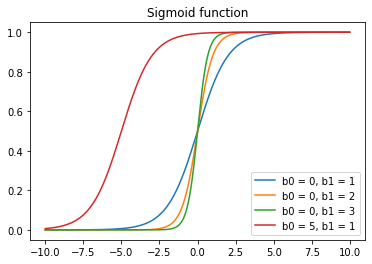

In [2]:
x = np.arange(-10, 10, 0.01)

def plot(b0, b1):
    p = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)

plot(0,1)
plot(0,2)
plot(0,3)
plot(5,1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

What is controlled by parameters b0, b1?  
<br><br> 
Let's now visualize the components of the Loss function:

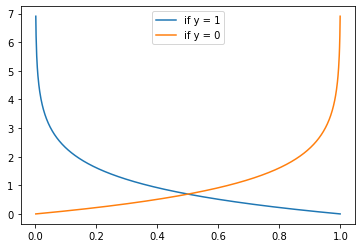

In [3]:
x = np.arange(0.001, 1, 0.001)
y1 = -np.log(x)
y0 = -np.log(1-x)

plt.plot(x,y1, label="if y = 1")
plt.plot(x,y0, label="if y = 0")
plt.legend()
plt.show()

What are the benefits of using logarithms in the loss function?   <br><br>

### Loading Data

In [4]:
import pandas as pd
data = pd.read_csv('/Users/levsvalov/code_workspace/Fall2020/ML/data/titanic.csv')
data

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,151.5500,S
2,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,151.5500,S
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,151.5500,S
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,151.5500,S
...,...,...,...,...,...,...,...,...,...
1304,0,3,"Zabour, Miss. Hileni",female,14.50,1,0,14.4542,C
1305,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,C
1306,0,3,"Zakarian, Mr. Mapriededer",male,26.50,0,0,7.2250,C
1307,0,3,"Zakarian, Mr. Ortin",male,27.00,0,0,7.2250,C


In [5]:
# removing name column
data = data.drop(['name'], axis = 1)

What do we know about the output class distribution? What percentage of people had survived? Is it important to have the same distribution in test and train sets? Why?

##### Task. Find and print the proporion of the positive (survived) class in the dataset, then split data to train and test sets preserving that proportion. Finally, as a check, calculate and print proportions in resulting sets.

In [6]:
from sklearn.model_selection import train_test_split

# find and print the proportion of positive samples in data

# split data
x = data.loc[:, 'pclass']
y = data['survived']
pos_proportion = 100 * sum(y == 1) / len(y)
print('% of positive samples in whole data:', pos_proportion)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# find and print the proportion of positive samples in train and test sets, make sure they are approx same
print('% of positive samples in train set:', 100 * sum(y_train == 1) / len(y_train))
print('% of positive samples in test set:', 100 * sum(y_test == 1) / len(y_test))

% of positive samples in whole data: 38.19709702062643
% of positive samples in train set: 38.2043935052531
% of positive samples in test set: 38.16793893129771


#### Data preprocessing

... is done for you! But you are free to change it if needed.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# imputing missing values
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(x_train)
x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# one-hot-encode categorical features
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['sex', 'embarked']
encoder.fit(x_train[f_names])
x_train = ohe_new_features(x_train, f_names, encoder)
x_test = ohe_new_features(x_test, f_names, encoder)

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

ValueError: Expected 2D array, got 1D array instead:
array=[3 2 3 ... 2 3 3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
x_train

### Logistic Regression

Now we are ready to see Logistic Regression in practice. 

#### Task. Fit Logistic Regression and output Accuracy, Precision, and Recall scores on test set.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression()
clf.fit(x_train, y_train)
# clf.predict(x)
# доделай!!!!
# y_pred = clf.predict(y_test)
# caclulate and print metrics
# print("Accuracy " + metrics.accuracy_score(y_test,y_pred) )
# print("average_precision" + metrics.average_precision_score(y_test,y_pred))
# print("average_precision"+ metrics.recall_score(y_test,y_pred))

What about Logistic Regression Coefficients? Can we interpret them?

In [ ]:
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

How can we choose a threshold? Let's try different ones and see their effect on metrics.

#### Task. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

In [ ]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# calculate metrics for each threshold above and plot the result as below.
y_pred_proba = clf.predict_proba(x_test)[:,1]
results = [[],[],[],[]]
for i in thresholds:
    y_pred = np.where(y_pred_proba>i,1,0)
    results[0].append(metrics.accuracy_score(y_test,y_pred))
    results[1].append(metrics.precision_score(y_test,y_pred))
    results[2].append(metrics.recall_score(y_test,y_pred))
    results[3].append(metrics.f1_score(y_test,y_pred))
    pass
plt.plot(thresholds,results[0], label='accuracy')
plt.plot(thresholds,results[1], label='precision')
plt.plot(thresholds,results[2], label='recall')
plt.plot(thresholds,results[3], label='f1 score')
plt.xlabel('threshold value')
plt.ylabel('score')
plt.legend
plt.grid()




### Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? 

<table><tr><td><img src='https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png'></td><td><img src='http://wiki.fast.ai/images/6/61/Confusion_matrix.png' style='width: 400px;'></td></tr></table>

<img align='center' src='https://www.researchgate.net/profile/Emanuele_Principi/publication/324226324/figure/fig2/AS:612091408941056@1522945372985/Normalized-confusion-matrix-of-best-performing-models-on-devel-subset-a-SVM.png' style='width: 350px;'>


In [ ]:
titanic_true_labels = np.array(y_test)
titanic_pred_labels = y_test_pred

In [ ]:
sample_true_labels = np.array([2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 0])
sample_pred_labels = np.array([2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2])

#### Task. You need to fill in the function which builds a Confusion Matrix based on true and predicted labels. Your solution should be generalizable to any number of classes. You can assume that classes are represented as numbers (0,1,2,3,...)

In [ ]:
def calc_confusion_matrix(true_labels, pred_labels):
    # Calculate a confusion matrix: 
    # True labels along Y axis, Predicted ones along X axis

    cm = []
    uniq = len(np.unique(true_labels))
    cm = np.zeros(shape=(uniq,uniq))
    for true_label, pred_label in zip(true_labels,pred_labels):
        cm[true_label][pred_label] +=1
    
    return cm

titanic_cm = calc_confusion_matrix(titanic_true_labels, titanic_pred_labels)
sample_cm = calc_confusion_matrix(sample_true_labels, sample_pred_labels)
print('Confusion Matrix for Titanic:\n', titanic_cm, '\n')
print('Confusion Matrix for Sample set:\n', sample_cm)

In [ ]:
# Run this block of code to see what your result should look like
from sklearn.metrics import confusion_matrix
print('TRUE Confusion Matrix for Titanic:\n', confusion_matrix(titanic_true_labels, titanic_pred_labels), '\n')
print('TRUE Confusion Matrix for Sample set:\n', confusion_matrix(sample_true_labels, sample_pred_labels))